In [1]:
# !echo '{"username":"mygaps","key":"c865d568876db7d1a9457943a3ac99bc"}' > ~/.kaggle/kaggle.json
# !kaggle competitions download -c anime-recommendation-rucode

In [1]:
!pip install catboost

     |████████████████████████████████| 67.3 MB 10.5 MB/s eta 0:00:01   |▊                               | 1.4 MB 1.6 MB/s eta 0:00:43     |████████████▎                   | 25.7 MB 12.1 MB/s eta 0:00:04     |███████████████████████▉        | 50.2 MB 10.6 MB/s eta 0:00:02     |████████████████████████▊       | 52.0 MB 10.6 MB/s eta 0:00:02     |███████████████████████████████ | 65.1 MB 10.5 MB/s eta 0:00:01
  Using cached plotly-4.14.3-py2.py3-none-any.whl (13.2 MB)
  Using cached graphviz-0.16-py2.py3-none-any.whl (19 kB)
  Using cached matplotlib-3.4.1-cp37-cp37m-manylinux1_x86_64.whl (10.3 MB)
  Using cached kiwisolver-1.3.1-cp37-cp37m-manylinux1_x86_64.whl (1.1 MB)
  Using cached pyparsing-2.4.7-py2.py3-none-any.whl (67 kB)
  Using cached cycler-0.10.0-py2.py3-none-any.whl (6.5 kB)
  Using cached retrying-1.3.3-py3-none-any.whl
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dep

In [3]:
from google.colab import drive
drive.mount('/content/drive')
import os
try:
    os.chdir("./drive/My Drive/RuCode/RuCode3/Рекомендации Аниме")
except Exception as e:
    print(e)
#  проверяем наличие файлов
directory = os.listdir()
directory

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['anime.csv',
 'sample_submission.csv',
 'user_ratings.csv',
 'submissions',
 'sub10.csv',
 'Решения',
 'collaborative-filtering-on-anime-data.ipynb',
 'baseline_ranking_estim.ipynb',
 'sub12.csv',
 'sub13.csv',
 'sub14.csv',
 'sub15.csv',
 'sub16.csv',
 'baseline_1.51.ipynb',
 'sub17.csv',
 'sub18.csv',
 'sub19.csv',
 'sub21.csv',
 'sub22.csv',
 'sub24.csv',
 'sub23.csv',
 'baseline_1.33359.ipynb',
 'ranker.ipynb',
 'baseline_catboost.ipynb',
 'catboost_info',
 'sub25.csv']

In [2]:
import numpy as np

def LabelEncoder(df, names):
    values = {}
    for name in df[names]:
        series = list(set(df[name]))
        values[name] = dict([[i, j] for i, j in zip(series,
                                                    range(len(series)))])
    return values

def to_encode(frame, names, encoding):
    df = frame.copy()
    for name in df[names]:
        df[name] = df[name].apply(lambda x: encoding[name].get(x, np.nan))
    return df

# Подготовка данных

In [3]:
import pandas as pd
import numpy as np

anime = pd.read_csv("anime.csv").replace("Unknown", np.nan)
ratings = pd.read_csv("user_ratings.csv", dtype=np.int32)
ratings = ratings.loc[ratings["rating"] != 0]
sample = pd.read_csv("sample_submission.csv")

In [4]:
sample_new = [[int(i) for i in id.split()] for id, rat in sample.values]
sample_df = pd.DataFrame(sample_new, columns=["user_id", "Id"])

In [5]:
ratings.head(3)

,user_id,anime_id,rating,watching_status,watched_episodes
0,0,121,8,1,0
1,0,12815,10,1,3
2,0,3588,9,1,13


In [25]:
import pickle
ratings["rol"] = pd.Series(pickle.load(open("tfcf_pred.pkl", 'rb')).tolist(), index=ratings.index)
ratings

,user_id,anime_id,rating,watching_status,watched_episodes,rol
0,0,121,8,1,0,8.445152
1,0,12815,10,1,3,8.776901
2,0,3588,9,1,13,8.526241
3,0,392,8,3,0,8.533208
4,1,1575,8,2,25,8.550097
...,...,...,...,...,...,...
19082564,98598,355,7,2,24,7.392707
19082565,98598,23273,9,2,22,8.652954
19082566,98598,34902,7,2,12,7.580277
19082567,98598,14813,8,2,13,7.720752


In [26]:
# делим данные
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(ratings.drop(["watching_status",
                                                 "watched_episodes"],
                                                axis=1),
                                   test_size=0.1,
                                   random_state=42)

In [27]:
X_train.head(3)

,user_id,anime_id,rating,rol
6147150,32104,41168,5,5.687671
12933307,66845,11981,10,8.949028
11253106,58330,916,6,6.530986


In [28]:
grouped_ratings = X_train[["user_id", "rating"]].groupby("user_id")\
                                                .agg(["median", "mean", "std",
                                                      "var", "count"])

additionally_user = pd.DataFrame(grouped_ratings.reset_index().values,
                                 columns=["user_id", "rating_median", "rating_mean",
                                          "rating_std", "rating_var", "num_watched"])

additionally_user.head(3)

,user_id,rating_median,rating_mean,rating_std,rating_var,num_watched
0,0.0,9.0,9.000000,1.000000,1.000000,3.0
1,1.0,7.0,7.283465,1.153997,1.331709,127.0
2,3.0,7.0,7.508197,1.287594,1.657899,183.0


In [29]:
categorical = ["Type", "Producers", "Licensors",
               "Studios", "Based on", "Age limit",
               "Duration"]

numeric = ["Avg score", "Num episodes", "In list",
           "In favourites", "Watching", "Finished",
           "On hold", "Dropped", "Planning to watch",
           "Group members", 'Score-10', 'Score-9',
           'Score-8', 'Score-7', 'Score-6',
           'Score-5', 'Score-4', 'Score-3',
           'Score-2', 'Score-1']

In [30]:
encode = LabelEncoder(anime, categorical)
anime_encode = to_encode(anime, categorical, encode)

ValueError: Length of passed values is 10905568, index implies 9815011.

In [19]:
import pickle
X_test["rol"] = pd.Series(pickle.load(open("tfcf_pred_test.pkl", 'rb')).tolist())

In [31]:
X_train_add = X_train.merge(additionally_user, how="left", on="user_id")\
                     .merge(anime_encode[categorical + numeric + ["Id"]],
                            how="left", left_on="anime_id", right_on="Id")\
                            .drop(["user_id", "Id", "anime_id"], axis=1).astype(np.float32)\
                            .drop_duplicates()

In [32]:
X_test_add = X_test.merge(additionally_user, how="left", on="user_id")\
                     .merge(anime_encode[categorical + numeric + ["Id"]],
                            how="left", left_on="anime_id", right_on="Id")\
                            .drop(["user_id", "Id", "anime_id"], axis=1).astype(np.float32)\
                            .drop_duplicates()

In [33]:
X_train_add.head(3)

,rating,rol,rating_median,rating_mean,rating_std,rating_var,num_watched,Type,Producers,Licensors,...,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
0,5.0,5.687671,6.0,6.146667,1.836932,3.374318,150.0,3.0,748.0,0.0,...,7370.0,12698.0,27257.0,30627.0,13340.0,5398.0,1996.0,742.0,331.0,219.0
1,10.0,8.949028,6.5,6.650000,2.192630,4.807627,60.0,6.0,1923.0,190.0,...,48733.0,47740.0,39369.0,19849.0,7796.0,3402.0,2097.0,1106.0,578.0,822.0
2,6.0,6.530986,7.0,7.589286,0.915862,0.838803,112.0,5.0,1300.0,122.0,...,869.0,1608.0,3244.0,5334.0,3998.0,2365.0,1295.0,587.0,297.0,201.0


In [34]:
X_train, y_train = X_train_add.drop(["rating"], axis=1), X_train_add["rating"]
X_test, y_test = X_test_add.drop(["rating"], axis=1), X_test_add["rating"]

In [46]:
from catboost import CatBoostRegressor

model = CatBoostRegressor(verbose=1,
                          iterations=1000,
                          random_state=42,
                          task_type="GPU",
                          loss_function="RMSE",
                          grow_policy="Depthwise",
                          use_best_model=True,
                         boost_from_average=True)

In [47]:
model.fit(X_train, y_train,
          eval_set=(X_test, y_test))

Learning rate set to 0.167584
0:	learn: 1.5661229	test: 1.5674796	best: 1.5674796 (0)	total: 78.6ms	remaining: 1m 18s
1:	learn: 1.4431708	test: 1.4442752	best: 1.4442752 (1)	total: 155ms	remaining: 1m 17s
2:	learn: 1.3513469	test: 1.3521775	best: 1.3521775 (2)	total: 233ms	remaining: 1m 17s
3:	learn: 1.2837615	test: 1.2843224	best: 1.2843224 (3)	total: 306ms	remaining: 1m 16s
4:	learn: 1.2347017	test: 1.2350428	best: 1.2350428 (4)	total: 374ms	remaining: 1m 14s
5:	learn: 1.1994739	test: 1.1996134	best: 1.1996134 (5)	total: 442ms	remaining: 1m 13s
6:	learn: 1.1743505	test: 1.1743628	best: 1.1743628 (6)	total: 508ms	remaining: 1m 12s
7:	learn: 1.1565633	test: 1.1564272	best: 1.1564272 (7)	total: 575ms	remaining: 1m 11s
8:	learn: 1.1440045	test: 1.1437841	best: 1.1437841 (8)	total: 639ms	remaining: 1m 10s
9:	learn: 1.1351470	test: 1.1348311	best: 1.1348311 (9)	total: 701ms	remaining: 1m 9s
10:	learn: 1.1289089	test: 1.1285201	best: 1.1285201 (10)	total: 765ms	remaining: 1m 8s
11:	learn: 1

96:	learn: 1.1089749	test: 1.1108536	best: 1.1108140 (87)	total: 5.62s	remaining: 52.4s
97:	learn: 1.1089568	test: 1.1108432	best: 1.1108140 (87)	total: 5.67s	remaining: 52.2s
98:	learn: 1.1089192	test: 1.1108213	best: 1.1108140 (87)	total: 5.72s	remaining: 52.1s
99:	learn: 1.1088924	test: 1.1108157	best: 1.1108140 (87)	total: 5.78s	remaining: 52s
100:	learn: 1.1088692	test: 1.1107683	best: 1.1107683 (100)	total: 5.83s	remaining: 51.9s
101:	learn: 1.1088473	test: 1.1107447	best: 1.1107447 (101)	total: 5.89s	remaining: 51.9s
102:	learn: 1.1088366	test: 1.1107399	best: 1.1107399 (102)	total: 5.95s	remaining: 51.8s
103:	learn: 1.1088049	test: 1.1106942	best: 1.1106942 (103)	total: 6.01s	remaining: 51.8s
104:	learn: 1.1087831	test: 1.1106752	best: 1.1106752 (104)	total: 6.07s	remaining: 51.7s
105:	learn: 1.1087458	test: 1.1106510	best: 1.1106510 (105)	total: 6.13s	remaining: 51.7s
106:	learn: 1.1087241	test: 1.1106395	best: 1.1106395 (106)	total: 6.2s	remaining: 51.7s
107:	learn: 1.1087089

188:	learn: 1.1072662	test: 1.1101665	best: 1.1101665 (188)	total: 10.4s	remaining: 44.6s
189:	learn: 1.1072537	test: 1.1101480	best: 1.1101480 (189)	total: 10.4s	remaining: 44.5s
190:	learn: 1.1072381	test: 1.1101430	best: 1.1101430 (190)	total: 10.5s	remaining: 44.4s
191:	learn: 1.1072203	test: 1.1101408	best: 1.1101408 (191)	total: 10.5s	remaining: 44.4s
192:	learn: 1.1072100	test: 1.1101304	best: 1.1101304 (192)	total: 10.6s	remaining: 44.3s
193:	learn: 1.1071963	test: 1.1101303	best: 1.1101303 (193)	total: 10.6s	remaining: 44.2s
194:	learn: 1.1071914	test: 1.1101267	best: 1.1101267 (194)	total: 10.7s	remaining: 44.1s
195:	learn: 1.1071844	test: 1.1101229	best: 1.1101229 (195)	total: 10.7s	remaining: 44s
196:	learn: 1.1071731	test: 1.1101139	best: 1.1101139 (196)	total: 10.8s	remaining: 44s
197:	learn: 1.1071602	test: 1.1101097	best: 1.1101097 (197)	total: 10.8s	remaining: 43.9s
198:	learn: 1.1071446	test: 1.1101149	best: 1.1101097 (197)	total: 10.9s	remaining: 43.8s
199:	learn: 1.

282:	learn: 1.1061108	test: 1.1098751	best: 1.1098751 (282)	total: 15.2s	remaining: 38.6s
283:	learn: 1.1061051	test: 1.1098705	best: 1.1098705 (283)	total: 15.3s	remaining: 38.5s
284:	learn: 1.1060873	test: 1.1098698	best: 1.1098698 (284)	total: 15.3s	remaining: 38.5s
285:	learn: 1.1060736	test: 1.1098609	best: 1.1098609 (285)	total: 15.4s	remaining: 38.5s
286:	learn: 1.1060605	test: 1.1098576	best: 1.1098576 (286)	total: 15.5s	remaining: 38.4s
287:	learn: 1.1060532	test: 1.1098612	best: 1.1098576 (286)	total: 15.5s	remaining: 38.4s
288:	learn: 1.1060382	test: 1.1098572	best: 1.1098572 (288)	total: 15.6s	remaining: 38.4s
289:	learn: 1.1060289	test: 1.1098417	best: 1.1098417 (289)	total: 15.7s	remaining: 38.3s
290:	learn: 1.1060226	test: 1.1098518	best: 1.1098417 (289)	total: 15.7s	remaining: 38.3s
291:	learn: 1.1060079	test: 1.1098542	best: 1.1098417 (289)	total: 15.8s	remaining: 38.2s
292:	learn: 1.1060016	test: 1.1098461	best: 1.1098417 (289)	total: 15.8s	remaining: 38.2s
293:	learn

374:	learn: 1.1052463	test: 1.1097099	best: 1.1096811 (366)	total: 20.6s	remaining: 34.3s
375:	learn: 1.1052365	test: 1.1097076	best: 1.1096811 (366)	total: 20.6s	remaining: 34.3s
376:	learn: 1.1052285	test: 1.1097107	best: 1.1096811 (366)	total: 20.7s	remaining: 34.2s
377:	learn: 1.1052215	test: 1.1097088	best: 1.1096811 (366)	total: 20.7s	remaining: 34.1s
378:	learn: 1.1052128	test: 1.1097063	best: 1.1096811 (366)	total: 20.8s	remaining: 34.1s
379:	learn: 1.1052049	test: 1.1096941	best: 1.1096811 (366)	total: 20.8s	remaining: 34s
380:	learn: 1.1051949	test: 1.1096889	best: 1.1096811 (366)	total: 20.9s	remaining: 34s
381:	learn: 1.1051883	test: 1.1096839	best: 1.1096811 (366)	total: 21s	remaining: 33.9s
382:	learn: 1.1051738	test: 1.1096796	best: 1.1096796 (382)	total: 21s	remaining: 33.8s
383:	learn: 1.1051666	test: 1.1096734	best: 1.1096734 (383)	total: 21.1s	remaining: 33.8s
384:	learn: 1.1051538	test: 1.1096758	best: 1.1096734 (383)	total: 21.1s	remaining: 33.7s
385:	learn: 1.1051

468:	learn: 1.1044190	test: 1.1097566	best: 1.1096353 (439)	total: 25.8s	remaining: 29.2s
469:	learn: 1.1044103	test: 1.1097564	best: 1.1096353 (439)	total: 25.8s	remaining: 29.1s
470:	learn: 1.1044051	test: 1.1097555	best: 1.1096353 (439)	total: 25.9s	remaining: 29.1s
471:	learn: 1.1043991	test: 1.1097535	best: 1.1096353 (439)	total: 26s	remaining: 29.1s
472:	learn: 1.1043906	test: 1.1097490	best: 1.1096353 (439)	total: 26s	remaining: 29s
473:	learn: 1.1043826	test: 1.1097518	best: 1.1096353 (439)	total: 26.1s	remaining: 28.9s
474:	learn: 1.1043759	test: 1.1097510	best: 1.1096353 (439)	total: 26.1s	remaining: 28.9s
475:	learn: 1.1043683	test: 1.1097407	best: 1.1096353 (439)	total: 26.2s	remaining: 28.8s
476:	learn: 1.1043561	test: 1.1097280	best: 1.1096353 (439)	total: 26.3s	remaining: 28.8s
477:	learn: 1.1043484	test: 1.1097480	best: 1.1096353 (439)	total: 26.3s	remaining: 28.7s
478:	learn: 1.1043426	test: 1.1097451	best: 1.1096353 (439)	total: 26.4s	remaining: 28.7s
479:	learn: 1.10

563:	learn: 1.1037000	test: 1.1098572	best: 1.1096353 (439)	total: 31s	remaining: 23.9s
564:	learn: 1.1036912	test: 1.1098551	best: 1.1096353 (439)	total: 31s	remaining: 23.9s
565:	learn: 1.1036840	test: 1.1098529	best: 1.1096353 (439)	total: 31.1s	remaining: 23.8s
566:	learn: 1.1036764	test: 1.1098467	best: 1.1096353 (439)	total: 31.1s	remaining: 23.8s
567:	learn: 1.1036698	test: 1.1098467	best: 1.1096353 (439)	total: 31.2s	remaining: 23.7s
568:	learn: 1.1036606	test: 1.1098487	best: 1.1096353 (439)	total: 31.2s	remaining: 23.7s
569:	learn: 1.1036533	test: 1.1098434	best: 1.1096353 (439)	total: 31.3s	remaining: 23.6s
570:	learn: 1.1036463	test: 1.1098365	best: 1.1096353 (439)	total: 31.4s	remaining: 23.6s
571:	learn: 1.1036424	test: 1.1098394	best: 1.1096353 (439)	total: 31.4s	remaining: 23.5s
572:	learn: 1.1036379	test: 1.1098376	best: 1.1096353 (439)	total: 31.5s	remaining: 23.5s
573:	learn: 1.1036326	test: 1.1098361	best: 1.1096353 (439)	total: 31.5s	remaining: 23.4s
574:	learn: 1.

655:	learn: 1.1030774	test: 1.1097639	best: 1.1096353 (439)	total: 36.5s	remaining: 19.1s
656:	learn: 1.1030714	test: 1.1097630	best: 1.1096353 (439)	total: 36.5s	remaining: 19.1s
657:	learn: 1.1030624	test: 1.1097692	best: 1.1096353 (439)	total: 36.6s	remaining: 19s
658:	learn: 1.1030538	test: 1.1097661	best: 1.1096353 (439)	total: 36.7s	remaining: 19s
659:	learn: 1.1030471	test: 1.1097651	best: 1.1096353 (439)	total: 36.7s	remaining: 18.9s
660:	learn: 1.1030355	test: 1.1097650	best: 1.1096353 (439)	total: 36.8s	remaining: 18.9s
661:	learn: 1.1030248	test: 1.1097617	best: 1.1096353 (439)	total: 36.8s	remaining: 18.8s
662:	learn: 1.1030171	test: 1.1097629	best: 1.1096353 (439)	total: 36.9s	remaining: 18.7s
663:	learn: 1.1030081	test: 1.1097625	best: 1.1096353 (439)	total: 36.9s	remaining: 18.7s
664:	learn: 1.1030052	test: 1.1097612	best: 1.1096353 (439)	total: 37s	remaining: 18.6s
665:	learn: 1.1030011	test: 1.1097623	best: 1.1096353 (439)	total: 37s	remaining: 18.6s
666:	learn: 1.1029

748:	learn: 1.1024572	test: 1.1097927	best: 1.1096353 (439)	total: 41.3s	remaining: 13.8s
749:	learn: 1.1024500	test: 1.1097956	best: 1.1096353 (439)	total: 41.3s	remaining: 13.8s
750:	learn: 1.1024434	test: 1.1097950	best: 1.1096353 (439)	total: 41.4s	remaining: 13.7s
751:	learn: 1.1024378	test: 1.1097993	best: 1.1096353 (439)	total: 41.4s	remaining: 13.7s
752:	learn: 1.1024331	test: 1.1098038	best: 1.1096353 (439)	total: 41.5s	remaining: 13.6s
753:	learn: 1.1024267	test: 1.1098034	best: 1.1096353 (439)	total: 41.5s	remaining: 13.5s
754:	learn: 1.1024195	test: 1.1098042	best: 1.1096353 (439)	total: 41.6s	remaining: 13.5s
755:	learn: 1.1024108	test: 1.1098054	best: 1.1096353 (439)	total: 41.6s	remaining: 13.4s
756:	learn: 1.1024041	test: 1.1098021	best: 1.1096353 (439)	total: 41.7s	remaining: 13.4s
757:	learn: 1.1023979	test: 1.1098034	best: 1.1096353 (439)	total: 41.7s	remaining: 13.3s
758:	learn: 1.1023916	test: 1.1098073	best: 1.1096353 (439)	total: 41.8s	remaining: 13.3s
759:	learn

841:	learn: 1.1019006	test: 1.1097968	best: 1.1096353 (439)	total: 45.9s	remaining: 8.62s
842:	learn: 1.1018964	test: 1.1097969	best: 1.1096353 (439)	total: 46s	remaining: 8.56s
843:	learn: 1.1018885	test: 1.1097918	best: 1.1096353 (439)	total: 46s	remaining: 8.51s
844:	learn: 1.1018803	test: 1.1097924	best: 1.1096353 (439)	total: 46.1s	remaining: 8.45s
845:	learn: 1.1018759	test: 1.1098000	best: 1.1096353 (439)	total: 46.1s	remaining: 8.4s
846:	learn: 1.1018679	test: 1.1097990	best: 1.1096353 (439)	total: 46.2s	remaining: 8.34s
847:	learn: 1.1018599	test: 1.1097982	best: 1.1096353 (439)	total: 46.2s	remaining: 8.29s
848:	learn: 1.1018539	test: 1.1098015	best: 1.1096353 (439)	total: 46.3s	remaining: 8.23s
849:	learn: 1.1018485	test: 1.1098107	best: 1.1096353 (439)	total: 46.3s	remaining: 8.17s
850:	learn: 1.1018437	test: 1.1098101	best: 1.1096353 (439)	total: 46.4s	remaining: 8.12s
851:	learn: 1.1018381	test: 1.1098101	best: 1.1096353 (439)	total: 46.4s	remaining: 8.06s
852:	learn: 1.1

936:	learn: 1.1013524	test: 1.1097833	best: 1.1096353 (439)	total: 50.7s	remaining: 3.41s
937:	learn: 1.1013473	test: 1.1097795	best: 1.1096353 (439)	total: 50.7s	remaining: 3.35s
938:	learn: 1.1013410	test: 1.1097786	best: 1.1096353 (439)	total: 50.8s	remaining: 3.3s
939:	learn: 1.1013353	test: 1.1097789	best: 1.1096353 (439)	total: 50.8s	remaining: 3.24s
940:	learn: 1.1013275	test: 1.1097777	best: 1.1096353 (439)	total: 50.9s	remaining: 3.19s
941:	learn: 1.1013234	test: 1.1097746	best: 1.1096353 (439)	total: 50.9s	remaining: 3.13s
942:	learn: 1.1013170	test: 1.1097748	best: 1.1096353 (439)	total: 51s	remaining: 3.08s
943:	learn: 1.1013076	test: 1.1097766	best: 1.1096353 (439)	total: 51s	remaining: 3.03s
944:	learn: 1.1013028	test: 1.1097741	best: 1.1096353 (439)	total: 51.1s	remaining: 2.97s
945:	learn: 1.1012970	test: 1.1097724	best: 1.1096353 (439)	total: 51.1s	remaining: 2.92s
946:	learn: 1.1012900	test: 1.1097702	best: 1.1096353 (439)	total: 51.2s	remaining: 2.87s
947:	learn: 1.1

In [48]:
sorted(zip(model.feature_names_, model.feature_importances_),
       key=lambda x: x[1], reverse=True)[:10]

[('rol', 98.48092562862958),
 ('num_watched', 0.27437078091236955),
 ('rating_std', 0.23241718897562158),
 ('rating_median', 0.17141161067756802),
 ('rating_mean', 0.15547272822042515),
 ('Avg score', 0.13705673879525404),
 ('Score-1', 0.053505451696437806),
 ('rating_var', 0.04994973441475626),
 ('Num episodes', 0.033555066477850136),
 ('Score-7', 0.028336980139353606)]

In [49]:
test = sample_df.merge(additionally_user, how="left", on="user_id")\
                .merge(anime_encode[categorical + numeric + ["Id"]], how="left",
                       on="Id")

In [50]:
additionally_user

,user_id,rating_median,rating_mean,rating_std,rating_var,num_watched
0,0.0,9.0,9.000000,1.000000,1.000000,3.0
1,1.0,7.0,7.283465,1.153997,1.331709,127.0
2,3.0,7.0,7.508197,1.287594,1.657899,183.0
3,4.0,7.0,7.130435,1.720577,2.960386,46.0
4,5.0,9.0,8.689655,1.072495,1.150246,29.0
...,...,...,...,...,...,...
95852,98594.0,9.0,9.066667,0.961150,0.923810,15.0
95853,98595.0,8.0,8.245902,1.306762,1.707628,122.0
95854,98596.0,9.0,8.520000,1.518890,2.307027,75.0
95855,98597.0,8.0,7.975610,1.202281,1.445481,205.0


# Отправка решения

In [51]:
pd.read_csv("tfcf_sub32 (1) (1).csv")

,Id,rating
0,0 249,8.097283
1,0 4181,8.367541
2,0 813,7.978248
3,0 2167,8.264830
4,1 1838,5.063227
...,...,...
876524,98598 15687,7.285507
876525,98598 1535,8.900617
876526,98598 37520,8.444215
876527,98598 35222,7.969700


In [52]:
test["rol"] = pd.read_csv("tfcf_sub32 (1) (1).csv")["rating"]
df_out = pd.DataFrame()
df_out["Id"] = test["user_id"].astype(str) + " " + test["Id"].astype(str)
df_out["rating"] = model.predict(test.drop(["user_id", "Id"], axis=1))
df_out.loc[df_out["rating"] < 0, "rating"] = 7.5
df_out.loc[df_out["rating"] > 10, "rating"] = 10
df_out.head(3)

,Id,rating
0,0 249,8.060621
1,0 4181,8.427228
2,0 813,8.025943


<AxesSubplot:>

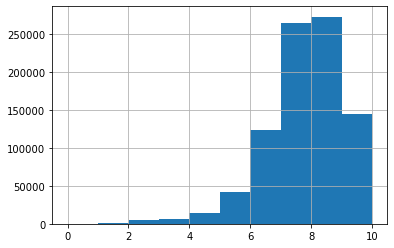

In [53]:
df_out["rating"].hist()

In [54]:
df_out.to_csv("sub289.csv", index=False)